# Sync overview

Feature layers includes a `Sync` capability, which when enabled, allows client applications to take feature layers offline, perform edits and sync it back to the layer. When you checkout some features and store it offline in the client, you call that a `replica`. The `FeatureLayerCollection` class under the `features` module allows users to create and work with replicas. The workflow of using sync involves these three operations:
- Create replica
- Synchronize replica
- Unregister replica

To learn more about this feature, refer to the [documentation here](http://resources.arcgis.com/en/help/arcgis-rest-api/index.html#//02r300000112000000)

## Checking out data from feature layers using replicas
To create a replica, we need a feature layer that is sync enabled. We can use the `syncEnabled` property of a `FeatureLayer` object to verify that. Further the `syncCapabilities` property returns a dictionary with fine grained sync capabilities

In [1]:
# connect to a GIS
from arcgis.gis import GIS
import arcgis.features
gis = GIS() # connect to www.arcgis.com anonymously. 
            # we will use a public sync enabled feature layer

To create and work with replicas, we need to create a `FeatureLayerCollection` object. A `FeatureLayerCollection` object can be created from either a feature layer `Item` or directly using a feature service URL.

Here, we will connect to a sample service by esri with URL `https://sampleserver6.arcgisonline.com/arcgis/rest/services/Sync/WildfireSync/FeatureServer/` 

In [ ]:
url = 'https://sampleserver6.arcgisonline.com/arcgis/rest/services/Sync/WildfireSync/FeatureServer/'
wildfire_flc = arcgis.features.FeatureLayerCollection(url, gis)

In [ ]:
type(wildfire_flc)

arcgis.features.layer.FeatureLayerCollection

### Verify if sync is enabled

Accessing the `layers` property on a `FeatureLayerCollection` returns a list of `FeatureLayer` objects. We can create a replica of one of these or all of these layers

In [ ]:
wildfire_flc.layers

[<FeatureLayer url:"https://sampleserver6.arcgisonline.com/arcgis/rest/services/Sync/WildfireSync/FeatureServer//0">,
 <FeatureLayer url:"https://sampleserver6.arcgisonline.com/arcgis/rest/services/Sync/WildfireSync/FeatureServer//1">,
 <FeatureLayer url:"https://sampleserver6.arcgisonline.com/arcgis/rest/services/Sync/WildfireSync/FeatureServer//2">]

In [ ]:
# query syncEnabled property to verify is sync is enabled
wildfire_flc.properties.syncEnabled

True

In [ ]:
# query the syncCapabilities property to view fine grained capabilities
wildfire_flc.properties.syncCapabilities

{
  "supportsRegisteringExistingData": true,
  "supportsPerReplicaSync": false,
  "supportsAttachmentsSyncDirection": true,
  "supportsPerLayerSync": true,
  "supportsRollbackOnFailure": false,
  "supportsSyncModelNone": true,
  "supportsSyncDirectionControl": true,
  "supportsAsync": true
}

### List existing replicas

The `replicas` property on a `FeatureLayerCollection` object returns you a `SyncManager` object. You would work with this manager object for all your sync workflows.

You can find if any replicas were created earlier on this layer by calling `get_list()` method on the `SyncManager` object.

In [ ]:
replica_list = wildfire_flc.replicas.get_list()
len(replica_list)

4255

As you can see, there are plenty of replicas on this layer. Let us view one of it

In [ ]:
replica_list[0]

{'replicaID': '29406BC5-55C4-4B63-BD60-D9DB6EA28D6F',
 'replicaName': 'Ags_Fs_1466602474959'}

### Create a replica
Now, let us create our own replica of this feature layer. The `create()` method accepts a number of parameters allowing you to adjust what needs to be replicated and customize other options. For more information on this operation, refer to the [documentation here](http://resources.arcgis.com/en/help/arcgis-rest-api/index.html#//02r3000000rp000000).

The full capability of the sync operation allows you to check out data from a feature layer, make edits and sync the deltas (changes) back to the server and update the features. This is popular in use cases which involve client applications such as ArcGIS Runtime or ArcGIS Desktop applications check out data, go offline (such as in areas where network connectivity is limited), make edits, then synchronize the data back to the server and update the features. The capability allows multiple clients to do this in parallel, thus enabling a large data collection effort.

However, if your purpose of a replica is only to check out the data (one directional), then you can verify if the `extract` capability is enabled on the feature layer and create a replica that is just meant for data check out. We will see this use case below:

In [ ]:
# list all capabilities
wildfire_flc.properties.capabilities

'Create,Delete,Query,Sync,Update,Uploads,Editing'

This layer has disabled 'Extract'. Hence let us search for a different layer

In [ ]:
portal_gis = GIS("portal url", "username", "password")
search_result = portal_gis.content.search("Ports along west coast", "Feature Layer")

<Item title:"Ports along west coast" type:Feature Service owner:arcgis_python_api>
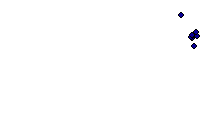

In [ ]:
search_result[0]

Let us create a `FeatureLayerCollection` object from this item

In [ ]:
ports_flc = arcgis.features.FeatureLayerCollection.fromitem(search_result[0])
type(ports_flc)

arcgis.features.layer.FeatureLayerCollection

#### Verify Extract capability

In [ ]:
ports_flc.properties.capabilities

'Query,Editing,Create,Update,Delete,Sync,Extract'

This is a suitable feature layer, let us extract the data into a file geodatabase and store it in local file system

In [ ]:
ports_flc = arcgis.features.FeatureLayerCollection.fromitem(sr[0])

In [ ]:
replica1 = ports_flc.replicas.create(replica_name = 'arcgis_python_api_2',
                                    layers='0',
                                    data_format='filegdb',
                                    out_path = 'E:\\demo')
replica1

'E:\\demo\\ad0dc00a447244f4b96aa39a30a4a093.zip'

Thus, we were able to checkout data from this feature layer into a file geodatabase. Clients can use this data in any way they wish, for instance, publish it as another feature layer to a different portal or just store it for archival.

## Removing replicas

The sync operation is expensive on the resources of your web GIS. Hence, it is a good maintenance practice to remove unnecessary replicas. An ArcGIS admin could use the ArcGIS Python API to script and automate the process of scanning all feature layers and removing stale replicas on each of them.

A replica can be removed by calling the `unregister()` method and passing the id of a replica that needs to be removed.

In [ ]:
# Let us query all the replicas registered on the ports feature layer from before
replica_list = ports_flc.replicas.get_list()

In [ ]:
for r in replica_list:
    print(r)

{'replicaName': 'SDS_FS', 'replicaID': '86E9D1D7-96FF-4B40-A366-DC9A9AAB6923'}
{'replicaName': 'SDS_FS_1481235956703', 'replicaID': '3B07459D-A23F-47D5-8E76-F3835E883A9D'}
{'replicaName': 'SDS_FS_1481236016125', 'replicaID': '662B83DA-6626-4BD1-8FAE-1A171EA5230B'}
{'replicaName': 'SDS_FS_1481236054393', 'replicaID': '38BAF9F8-34FE-4153-AE9C-2756992A49F5'}
{'replicaName': 'SDS_FS_1481236093401', 'replicaID': '3CB074DB-BA87-4E05-8235-F981FE5C601E'}


There are more than a few. I only want to remove the replicas that were registered 10 minutes ago. But, your search criteria could be any other. 

We will loop through each of the replicas returned and use the `get()` method to get detailed information about these replicas and look a `creationDate` property.

Before looping, let us take a deeper look at one of these replicas by calling the `get()` method:

In [ ]:
replica1 = ports_flc.replicas.get('86E9D1D7-96FF-4B40-A366-DC9A9AAB6923')
replica1

{'attachmentsSyncDirection': 'bidirectional',
 'creationDate': 1481235395998,
 'geometry': {'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
  'xmax': -12351726.0067822,
  'xmin': -18249471.330872223,
  'ymax': 7382319.928103409,
  'ymin': 341526.2431555473},
 'lastSyncDate': 1481235395998,
 'layerServerGens': [{'id': 0, 'serverGen': 1481235395998}],
 'layers': [{'id': 0,
   'includeRelated': True,
   'queryOption': 'useFilter',
   'useGeometry': True,
   'where': ''}],
 'replicaID': '86E9D1D7-96FF-4B40-A366-DC9A9AAB6923',
 'replicaName': 'SDS_FS',
 'replicaOwner': 'arcgis_python_api',
 'returnsAttachments': True,
 'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
 'spatialRel': 'esriSpatialRelIntersects',
 'syncModel': 'perLayer',
 'targetType': 'client'}

The `creationDate` key is retured as unix epoch time. We need to convert it to local time for processing:

In [ ]:
import time
time.localtime(replica1['creationDate']/1000) #dividing by 1000 to convert micro seconds to seconds

time.struct_time(tm_year=2016, tm_mon=12, tm_mday=8, tm_hour=14, tm_min=16, tm_sec=35, tm_wday=3, tm_yday=343, tm_isdst=0)

To determine those replicas that were created 10 mins earlier, let us create an epoch timestamp for 10 mins before now and find those replicas whose time stamps are lower than this

In [ ]:
ten_min_earlier_epoch = time.time() - 10
ten_min_earlier_epoch

1481238022.105653

In [ ]:
import time
removal_list = []
for r in replica_list:
    temp_r = ports_flc.replicas.get(r['replicaID'])
    temp_dict = {'replica_id': r['replicaID'],
                'creationDate':temp_r['creationDate']/1000}
    
    #check
    if temp_dict['creationDate'] < ten_min_earlier_epoch:
        removal_list.append(temp_dict)
        print(temp_dict)

{'creationDate': 1481235395.998, 'replica_id': '86E9D1D7-96FF-4B40-A366-DC9A9AAB6923'}
{'creationDate': 1481235955.848, 'replica_id': '3B07459D-A23F-47D5-8E76-F3835E883A9D'}
{'creationDate': 1481236015.278, 'replica_id': '662B83DA-6626-4BD1-8FAE-1A171EA5230B'}
{'creationDate': 1481236053.455, 'replica_id': '38BAF9F8-34FE-4153-AE9C-2756992A49F5'}
{'creationDate': 1481236092.515, 'replica_id': '3CB074DB-BA87-4E05-8235-F981FE5C601E'}


Let us loop through each of these replicas and remove them using the `unregister()` method:

In [ ]:
for r in removal_list:
    result = ports_flc.replicas.unregister(r['replica_id'])
    print(result)

{'success': True}
{'success': True}
{'success': True}
{'success': True}
{'success': True}
